# Spherical Integration in PICASO

In this tutorial you will learn the different integration schemes that exist within `PICASO`.

In [1]:
import numpy as np

#picaso
from picaso import justdoit as jdi
from picaso import justplotit as jpi

jpi.output_notebook()

Loading BokehJS ...

## Test Geometry with Brown Dwarf Sonora Example

Let's try three different cases

In [2]:
wave_range = [3,5]

opa = jdi.opannection(wave_range=wave_range)

case1 = jdi.inputs(calculation='browndwarf')

case2 = jdi.inputs(calculation='browndwarf')

case3 = jdi.inputs(calculation='browndwarf')



First case will be a full 10x10 grid, second will be the same 10x10 grid but leveraging symmetry, last will be a 1x10 grid. A 1x10 grid automatically leverages symmetry as we will see in the disco plots below.

In [3]:
names = ['10x10', '10x10sym', '1x10']
cases = [ case1, case2, case3]#, case5]

case1.phase_angle(num_tangle=10, num_gangle=10)
case2.phase_angle(num_tangle=10, num_gangle=10, symmetry=True)
case3.phase_angle(num_tangle=1, num_gangle=10) #remember num_tangle=1 automatically insinuates symmetry

#### Query from Sonora Profile Grid

(Same as before) Download the profile files that are located in the [profile.tar file](https://zenodo.org/record/1309035#.Xo5GbZNKjGJ)

Once you untar the file you can set the file path below. You do not need to unzip each profile. `picaso` will do that upon read in. `picaso` will find the nearest neighbor and attach it to your class.

In [4]:
# Note here that we do not need to provide case.star, since there is none!
for i in cases:i.gravity(gravity=100 , gravity_unit=jdi.u.Unit('m/s**2'))

#grab sonora profile
# sonora_profile_db = '/data/sonora_profile/'
sonora_profile_db = jdi.os.path.join(jdi.os.getenv('picaso_refdata'),'sonora_grids','bobcat')

Teff = 900
#this function will grab the gravity you have input above and find the nearest neighbor with the
#note sonora chemistry grid is on the same opacity grid as our opacities (1060).
for i in cases:i.sonora(sonora_profile_db, Teff)

#### Run Spectrum

In [5]:
df = {}
for i,ikey in zip(cases, names):
    print(ikey)
    df[ikey] = i.spectrum(opa, full_output=True)

10x10


10x10sym


1x10


#### Convert Units and Regrid

In [6]:
for i,ikey in zip(cases, names):
    print(ikey)
    x,y = df[ikey]['wavenumber'], df[ikey]['thermal'] #units of erg/cm2/s/cm
    #converts from picaso default units (can also specify original unit if different from picaso via kwarg f_unit and xgrid_unit)
    fluxnu= jdi.convert_flux_units(x,y , to_f_unit = 'erg*cm^(-2)*s^(-1)*Hz^(-1)')

    df[ikey]['fluxnu'] = fluxnu
    binx,biny = jdi.mean_regrid(x, fluxnu, R=300) #wavenumber, erg/cm2/s/Hz
    df[ikey]['regridy'] =  biny
    df[ikey]['regridx'] =binx

10x10
10x10sym
1x10


### Compare Different Integration Schemes with Sonora Grid

In [7]:
son = jdi.pd.read_csv('sp_t900g100nc_m0.0',sep=r'\s+',
                 skiprows=3,header=None,names=['w','f'])
sonx, sony =  jdi.mean_regrid(1e4/son['w'], son['f'], newx=binx)

In [8]:
to_compare = []
fraction_compare = []
for ikey in names:
    to_compare += [df[ikey]['regridy']]
    fraction_compare += [df[ikey]['regridy']/sony]

In [9]:
to_compare += [sony]
legend_label = names + ['sonora']

### Compare Accuracy of Different Number of Integration Points

In [10]:
jpi.show(jpi.spectrum([binx]*len(to_compare),to_compare, legend=legend_label
                  ,plot_width=800,x_range=wave_range,y_axis_type='log'))

### Visualize Integration Schemes

10x10


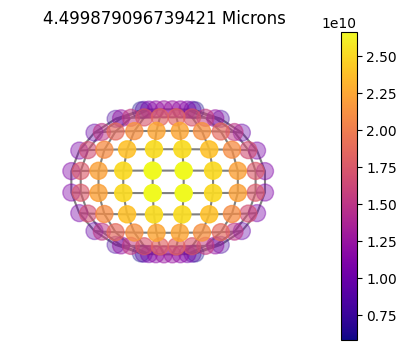

10x10sym


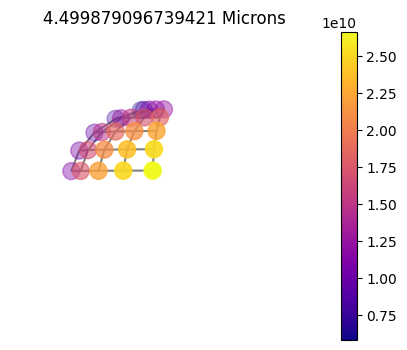

1x10


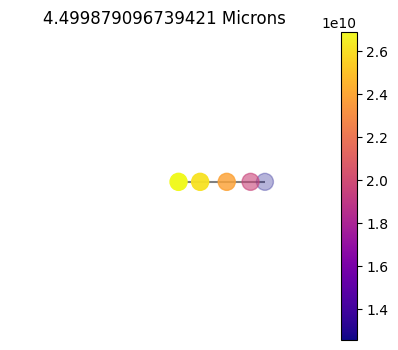

In [11]:
for ikey in names:
    asdict = df[ikey]['full_output']
    print(ikey)
    jpi.disco(asdict, calculation='thermal', wavelength=[4.5])

### Plot Gauss Weights

Plotting out the gauss weights you can see the difference between the purely 1D (without using chebyshev weights), 2D full grid and 2D symmetric.

In [12]:
fig = jpi.figure(height=300, x_axis_label='gangle',y_axis_label='gweight')
for i in [fig.line, fig.scatter]: i(cases[0].inputs['disco']['gangle'],
         cases[0].inputs['disco']['gweight'],color='red',
                                  legend_label=names[0]  )

for i in [fig.line, fig.scatter]: i(cases[1].inputs['disco']['gangle'],
         cases[1].inputs['disco']['gweight'],color='blue',
                                 legend_label=names[1] )

for i in [fig.line, fig.scatter]: i(cases[2].inputs['disco']['gangle'],
         cases[2].inputs['disco']['gweight']
                                   ,color='green',legend_label=names[2])


jpi.show(fig)

## Geometry with Reflectivity and Non-Zero Phase

In this example, let's look at four difference cases.

1) 1x10 symmetric grid with zero phase (inherently symmetric)

2) 10x10 grid with zero phase but let's run without symmetry utilization

3) same as 2 but flipping on symmetry

4) Non-zero phase, full grid

In [13]:
wave_range = [0.3,1]

opa = jdi.opannection(wave_range=wave_range)

case1 = jdi.inputs()
case2 = jdi.inputs()
case3 = jdi.inputs()
case4 = jdi.inputs()

In [14]:
names = ['1x10','10x10', '10x10sym',  '10x10_60']

case1.phase_angle(phase=0, num_tangle=1, num_gangle=10) #remember num_tangle=1 automatically insinuates symmetry
case2.phase_angle(phase=0, num_tangle=10, num_gangle=10)
case3.phase_angle(phase=0, num_tangle=10, num_gangle=10, symmetry=True)
case4.phase_angle(phase=60*np.pi/180, num_tangle=10, num_gangle=10)

cases = [ case1, case2, case3, case4]

In [15]:
for i in cases:i.gravity(gravity=20 , gravity_unit=jdi.u.Unit('m/s**2'))
for i in cases:i.atmosphere(filename = jdi.jupiter_pt(), sep=r'\s+')
for i in cases:i.approx(raman='pollack')
for i in cases:i.star(opa, 5000,0,4.0)

In [16]:
df = {}
for i,ikey in zip(cases, names):
    print(ikey)
    df[ikey] = i.spectrum(opa,calculation='reflected' ,full_output=True)

1x10


10x10


10x10sym


10x10_60


In [17]:
to_compare = []
for ikey in names:
    x,y = df[ikey]['wavenumber'], df[ikey]['albedo']
    x,y = jdi.mean_regrid(x, y, R=100) #wavenumber, erg/cm2/s/Hz
    df[ikey]['regridy'] =  y
    df[ikey]['regridx'] = x
    to_compare += [df[ikey]['regridy']]

In [18]:
jpi.show(jpi.spectrum([x]*len(to_compare),to_compare, legend=names
                  ,plot_width=800))

If you zoom in, you will notice that the 1x10 is just slightly off the full 10x10 grid. This is certainly not enough to warrant doing a full 10x10=100 calculations opposed to the 10/2x1=5 calculations it too to run the 1x10 grid (you can see what RT points were ran below).

In [19]:
asdict.keys()

dict_keys(['weights', 'layer', 'wavenumber', 'wavenumber_unit', 'taugas', 'tauray', 'taucld', 'level', 'latitude', 'longitude', 'star', 'thermal_unit', 'thermal_3d', 'warnings'])

1x10


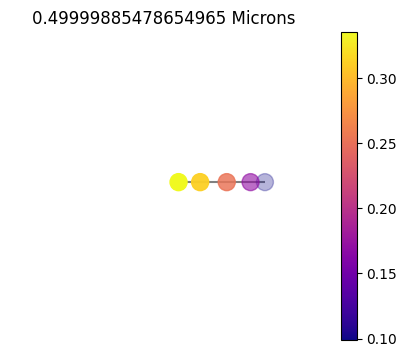

10x10


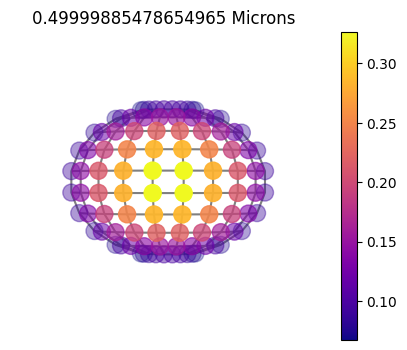

10x10sym


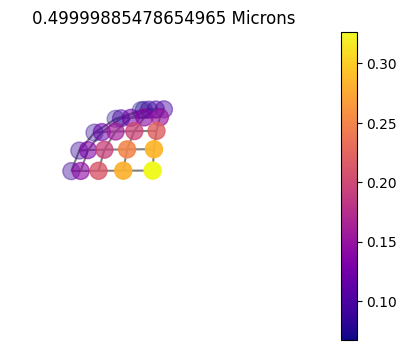

10x10_60


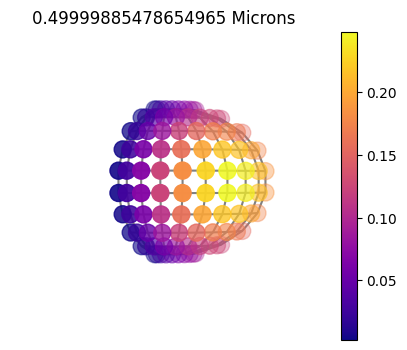

In [20]:
for ikey in names:
    asdict = df[ikey]['full_output']
    print(ikey)
    jpi.disco(asdict, calculation='reflected', wavelength=[0.5])